In [572]:
#Import necessary packages 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [573]:
# suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

The  data  is  available  as  two  attached  CSV  files:

`takehome_user_engagement.csv`

`takehome_users.csv`


The  data  has  the  following  two  tables:

 1  A  user  table  ( "takehome_users" )  with  data  on  12,000  users  who  signed  up  for  the
 product  in  the  last  two  years.   This  table  includes:
 
    ● name:  the  user's  name
    ● object_id:   the  user's  id
    ● email:  email  address
    ● creation_source:   how  their  account  was  created.  This  takes  on  oneof  5  values:
        ○ PERSONAL_PROJECTS:  invited  to  join  another  user's personal  workspace
        ○ GUEST_INVITE:  invited  to  an  organization  as  a  guest(limited  permissions)
        ○ ORG_INVITE:  invited  to  an  organization  (as  a  full  member)
        ○ SIGNUP:  signed  up  via  the  website
        ○ SIGNUP_GOOGLE_AUTH:  signed  up  using  Google Authentication  (using  a  Google  email  account  for  their loginid)
    ● creation_time:  when  they  created  their  account
    ● last_session_creation_time:   unix  timestamp  of  last  login
    ● opted_in_to_mailing_list:  whether  they  have  opted  into  receiving  marketing  emails
    ● enabled_for_marketing_drip:  whether  they  are  on  the  regular marketing  email  drip
    ● org_id:   the  organization  (group  of  users)  they  belong  to
    ● invited_by_user_id:   which  user  invited  them  to  join  (if  applicable).
 2  A  usage  summary  table  ( "takehome_user_engagement" )  that  has  a  row  for  each  day
that  a  user  logged  into  the  product

Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate
days  in  at  least  one  seven­day  period ,  identify  which  factors  predict  future  user
adoption .
We  suggest  spending  1-2  hours  on  this,  but  you're  welcome  to  spend  more  or  less.
Please  send  us  a  brief  writeup  of  your  findings  (the  more  concise,  the  better  ­­  no  more
than  one  page),  along  with  any  summary  tables,  graphs,  code,  or  queries  that  can  help
us  understand  your  approach.  Please  note  any  factors  you  considered  or  investigation
you  did,  even  if  they  did  not  pan  out.  Feel  free  to  identify  any  further  research  or  data
you  think  would  be  valuable

## Data Wrangling

Load the data and take a peek.

In [574]:
## Load data 
df1 = pd.read_csv("takehome_users.csv", encoding_errors='replace')
df2 = pd.read_csv("takehome_user_engagement.csv")

In [575]:
df1.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [576]:
df2.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [577]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [578]:
print("There were {} unique users and {} distinct logins in the user_engagement file"
      .format(df2['user_id'].nunique(), len(df2)))
                                                                                             

There were 8823 unique users and 207917 distinct logins in the user_engagement file


In [579]:
print("This corresponds with the {} nonnull values in last_session_creation_time of the users file".format(len(df1[~df1['last_session_creation_time'].isnull()])))

This corresponds with the 8823 nonnull values in last_session_creation_time of the users file


### Find the adopted users

In [580]:
import datetime

#set the time_stamp to datetime and the set it as the index
df2.time_stamp = pd.to_datetime(df2.time_stamp)
df2 = df2.set_index('time_stamp', drop= True)

In [581]:
from datetime import timedelta

def label_adopted(x):    
    "takes a users input and returns whether or not they have been active within any 7-day period"
    df_temp = df2.loc[df2['user_id'] == x] #select out rows of this user
    df_temp = df_temp.resample('D').mean().dropna() #resample to show if active in a day. .mean() is just of 1
    adopted = 0
    for i in range(len(df_temp)-2): #loop over active days till the second to last day
        if df_temp.index[i + 2] - df_temp.index[i] <= timedelta(days=7): # difference between every 1st and 3rd day
            adopted = 1
            break
        else:
            adopted = 0
    return adopted 


    

In [582]:
#apply to  df1 to label users as adopted=true 
df1['adopted_user'] = df1['object_id'].apply(label_adopted)

In [583]:
print("There are {} adopted users out of the total {} users.".format(adopted_users.sum(),len(adopted_users)))

There are 1656 adopted users out of the total 8823 users.


In [584]:
df1.set_index('object_id')
df1.index.name = 'user_id'
df1.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
user_id,,,,,,,,,,,
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [585]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  adopted_user                12000 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 1.0+ MB


Convert the `creation_time` and `last_session_creation_time` to datetime objects.

In [587]:
df1['creation_time'] = pd.to_datetime(df1['creation_time'])

df1['last_session_creation_time'] = df1['last_session_creation_time'].map(lambda data: 
                                    datetime.datetime.fromtimestamp(int(data)).strftime('%Y-%m-%d %H:%M:%S'),na_action='ignore')

df1['last_session_creation_time'] = pd.to_datetime(df1['last_session_creation_time'])                                                                              

In [588]:
#subtract to find time active
df1['activity_length'] = df1['last_session_creation_time'] - df1['creation_time']
#lets settle for seconds instead of days to make the time differences more distinct
df1['activity_length'] = [x.total_seconds() for x in df1['activity_length']]

Find the time between these two times as `activity_length` in seconds.

In [589]:
df1['activity_length'] = df1['last_session_creation_time'] - df1['creation_time']
df1['activity_length'] = [x.total_seconds() for x in df1['activity_length']]
#df1.info()

In [590]:
df1.groupby('adopted_user')['activity_length'].mean()

adopted_user
0    4.368216e+05
1    2.525076e+07
Name: activity_length, dtype: float64

Activity length seems to be much longer for adopted than unadopted users.

Let's also count how many users were invited by a user.

In [591]:
invited_count = df1.groupby('invited_by_user_id')['object_id'].count()
invited_count.name = 'invited_count'

In [592]:
len(invited_count[invited_count > 0])

2564

In [593]:
df1 = df1.merge(invited_count, how='left',left_on='object_id', right_index=True )

In [594]:
df1['invited_count'].fillna(0, inplace=True)

In [595]:
df1.groupby('adopted_user')['invited_count'].mean()

adopted_user
0    0.510731
1    0.684783
Name: invited_count, dtype: float64

This also seems useful.

In [596]:
df1.invited_by_user_id = df1.invited_by_user_id.fillna(0)

In [597]:
df = df1.iloc[:,4:]
df = df.drop('last_session_creation_time', axis=1)
#df = df.drop('invited_count', axis=1)
df['activity_length'] = df['activity_length'].fillna(0)

Encode the categorical variables.

In [598]:
from sklearn.preprocessing import LabelEncoder

gle = LabelEncoder()
creation_labels = gle.fit_transform(df1['creation_source'])
df.creation_source = creation_labels

org_id_labels = gle.fit_transform(df1['org_id'])
df.org_id = org_id_labels

invited_labels = gle.fit_transform(df1['invited_by_user_id'])
df.invited_by_user_id = invited_labels

In [599]:
df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,activity_length,invited_count
user_id,,,,,,,,
0,0,1,0,11,2325,0,-21600.0,0.0
1,1,0,0,1,56,1,11728800.0,0.0
2,1,0,0,94,298,0,-21600.0,1.0
3,0,0,0,1,1104,0,64800.0,0.0
4,0,0,0,193,1127,0,406800.0,0.0


In [600]:
X = df.drop('adopted_user', axis=1)
y = df.adopted_user
X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.33, random_state=714)

In [601]:
from sklearn.ensemble import RandomForestClassifier

#train and test classifier
rf = RandomForestClassifier(class_weight='balanced_subsample')

rf.fit(X_train, X_test)

rf.score(y_train, y_test)

0.967929292929293

Well that looks great. 

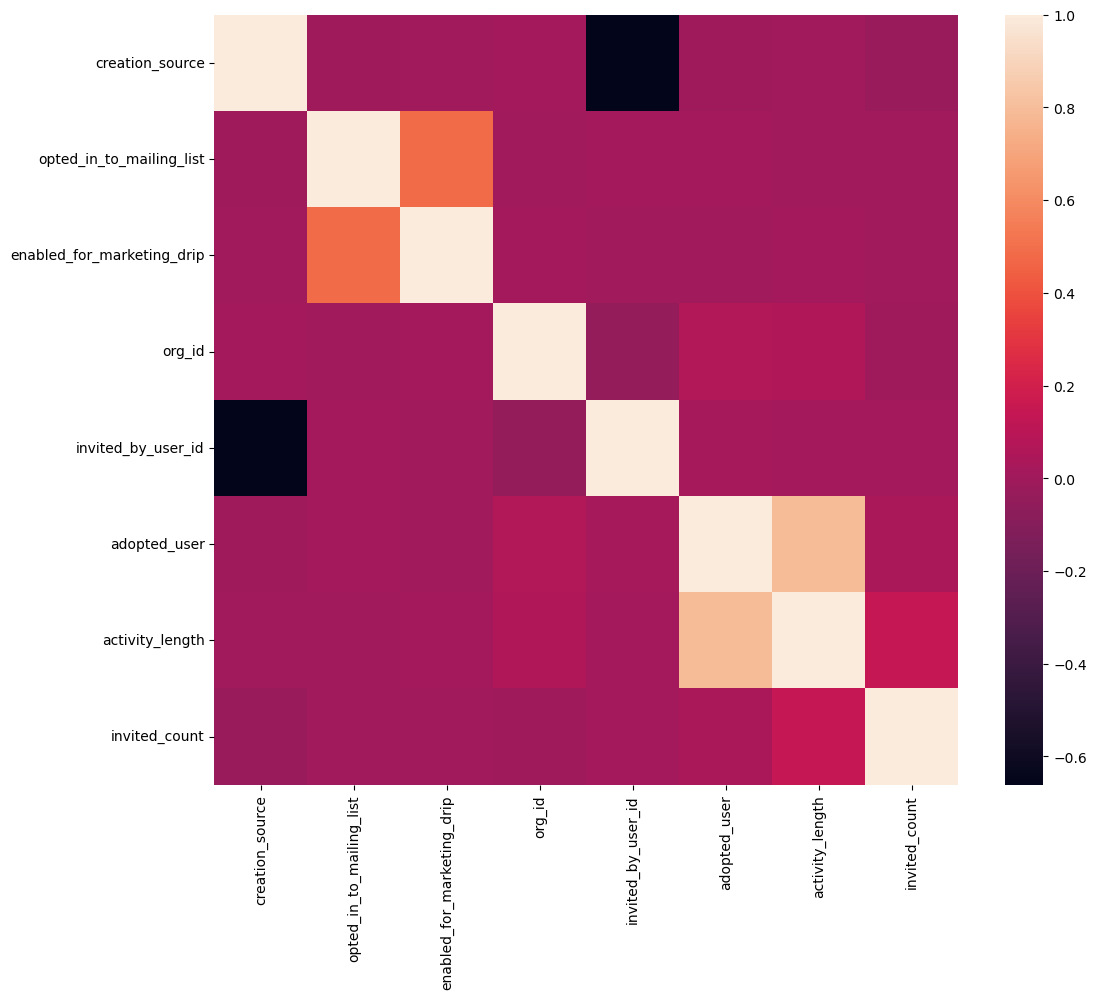

In [602]:
plt.subplots(figsize=(12,10))
sns.heatmap(df.corr());

Seems like the created features are correlated to the target.

In [603]:
from sklearn.metrics import classification_report, confusion_matrix

#print out classification report and confusion matrix
y_pred = rf.predict(y_train)

print(classification_report(y_test, y_pred))
print('confusion matrix:')
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3414
           1       0.90      0.87      0.88       546

    accuracy                           0.97      3960
   macro avg       0.94      0.93      0.93      3960
weighted avg       0.97      0.97      0.97      3960

confusion matrix:
[[3360   54]
 [  73  473]]


Still loooks great. We could probably improve slightly with a parameter grid.

Let's see which features are the most important.

In [604]:
#make a df that displays the cofficients indexed by feature name
feature_importance = pd.DataFrame()
feature_importance['coef'] = rf.feature_importances_
feature_importance = feature_importance.set_index(X.columns)
feature_importance.coef.nlargest(10)

activity_length               0.895520
org_id                        0.050701
invited_by_user_id            0.025189
creation_source               0.012270
invited_count                 0.009731
opted_in_to_mailing_list      0.003645
enabled_for_marketing_drip    0.002945
Name: coef, dtype: float64

In [605]:
#define func to find ecdf of dataset
def ecdf(array):
    """Compute Estimated CDF for a one-dimensional array."""
    n = len(array)
    x = np.sort(array)
    y = np.arange(1, n+1) / n
    return x, y

Plot the Estimated CDF for `adopted` and `Non-adopted` 

In [606]:
adopted = df.activity_length.loc[df['adopted_user'] == 1]
not_adopted = df.activity_length.loc[df['adopted_user'] == 0]

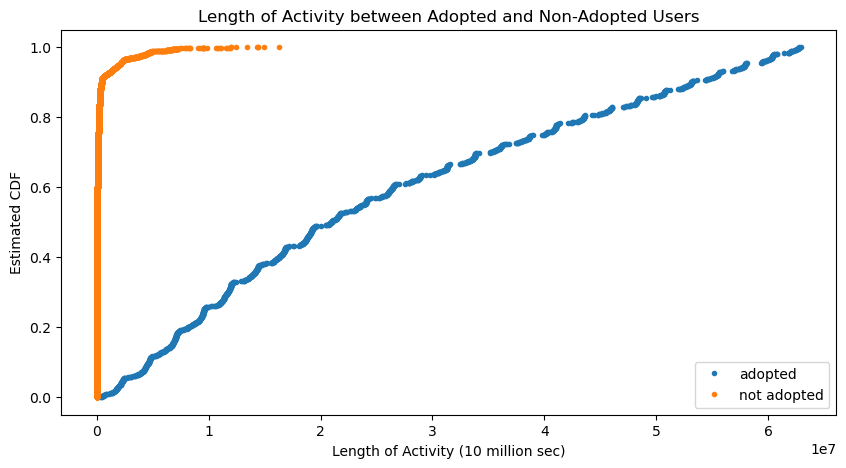

In [607]:
#set fig size
%matplotlib inline
plt.figure(figsize=(10,5))

x_active, y_active = ecdf(adopted)
x_inactive, y_inactive = ecdf(not_adopted)

plt.plot(x_active, y_active, marker='.', linestyle='none')
plt.plot(x_inactive, y_inactive, marker='.', linestyle='none')
plt.title('Length of Activity between Adopted and Non-Adopted Users')
plt.xlabel('Length of Activity (10 million sec)')
plt.ylabel('Estimated CDF')
plt.legend(['adopted', 'not adopted'])
plt.show()

Clearly, activity length is a great indicator as the activity of non-adopted users drops of quickly and it appears the maximum of non-adopted users is right around the median of the adopted users.

